# Output Analysis

This notebook contains our analysis of the recommender evaluation results.

## Setup

Libraries:

In [1]:
library(MASS)
library(plyr)
library(dplyr)
library(readr)
library(ggplot2)
library(reshape2)


Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from 'package:MASS':

    select

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [2]:
options(repr.plot.height=5)
options(repr.matrix.max.rows=20)
options(repr.matrix.max.columns=10)

## Read Data

In [3]:
users.meta = read_delim("data/ml-1m/users.dat", delim=":",
                   col_names=c("user", "gender", "age", "occupation", "zip"),
                   col_types="i_c_c_c_c") %>%
    mutate(gender=as.factor(gender),
           age=as.factor(age),
           occupation=as.factor(occupation))
users.meta

user,gender,age,occupation,zip
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455
6,F,50,9,55117
7,M,35,1,06810
8,M,25,12,11413
9,M,25,17,61614
10,F,35,1,95370


In [4]:
train.ratings = ldply(1:5, function(part) {
    message("reading part ", part)
    test.fn = sprintf("build/crossfold.out/part0%d.test.csv", part)
    train.fn = sprintf("build/crossfold.out/part0%d.train.csv", part)
    test = suppressMessages(read_csv(test.fn, col_names=c("user", "item", "rating", "timestamp")))
    train = suppressMessages(read_csv(train.fn, col_names=c("user", "item", "rating", "timestamp")))
    data.frame(user=unique(test$user), part=part) %>%
        inner_join(train)
})

reading part 1
Joining, by = "user"
reading part 2
Joining, by = "user"
reading part 3
Joining, by = "user"
reading part 4
Joining, by = "user"
reading part 5
Joining, by = "user"


In [5]:
user.stats = train.ratings %>%
    group_by(user) %>%
    summarize(nratings = n())

In [6]:
users = users.meta %>% inner_join(user.stats)
users

Joining, by = "user"


user,gender,age,occupation,zip,nratings
1,F,1,10,48067,42
2,M,56,16,70072,103
3,M,25,15,55117,41
4,M,45,7,02460,17
5,M,25,20,55455,158
6,F,50,9,55117,57
7,M,35,1,06810,25
8,M,25,12,11413,111
9,M,25,17,61614,85
10,F,35,1,95370,321


In [7]:
user.results = read_csv("build/eval-users.csv", guess_max=10000) %>%
    rename(user=User) %>%
    inner_join(users)

Parsed with column specification:
cols(
  DataSet = col_character(),
  Partition = col_integer(),
  Algorithm = col_character(),
  User = col_integer(),
  TestTime = col_double(),
  RMSE = col_double(),
  Predict.nDCG = col_double(),
  Predict.nDCG.Raw = col_double(),
  TopN.nDCG = col_double(),
  Rank = col_integer(),
  RecipRank = col_double(),
  AvgPrec = col_double()
)
Joining, by = "user"


## Gender Analysis

Let's analyze accuracy by gender.

In [22]:
gender.results = user.results %>%
    group_by(Algorithm, gender) %>%
    summarize(MAP=mean(AvgPrec), MRR=mean(RecipRank),
              RMSE=mean(RMSE),
              nDCG=mean(TopN.nDCG),
              Rank.nDcG=mean(Predict.nDCG)) %>%
    ungroup()
gender.tall = melt(gender.results, variable.name = "Metric")

Using Algorithm, gender as id variables


In [23]:
overall.results = user.results %>%
    group_by(Algorithm) %>%
    summarize(MAP=mean(AvgPrec), MRR=mean(RecipRank),
              RMSE=mean(RMSE),
              nDCG=mean(TopN.nDCG),
              Rank.nDcG=mean(Predict.nDCG)) %>%
    ungroup() %>%
    mutate(gender = 'Any')
combined.results = rbind(gender.results, overall.results)
combined.tall = melt(combined.results, variable.name = "Metric")

Using Algorithm, gender as id variables


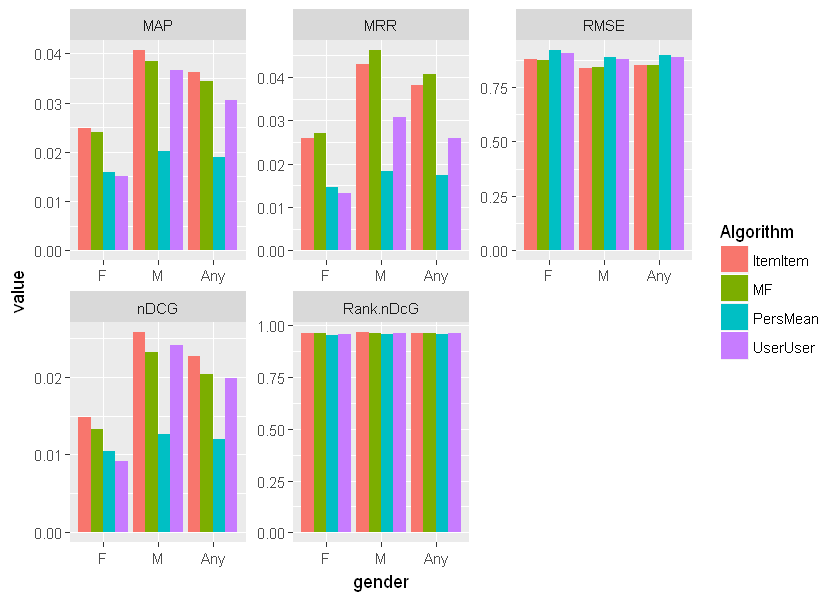

In [24]:
ggplot(combined.tall) +
    aes(x=gender, y=value, fill=Algorithm) +
    geom_bar(stat="identity", position="dodge") +
    facet_wrap(~ Metric, scales="free")

## Age!

In [10]:
age.results = user.results %>%
    group_by(Algorithm, age) %>%
    summarize(MAP=mean(AvgPrec), MRR=mean(RecipRank),
              RMSE=mean(RMSE),
              nDCG=mean(TopN.nDCG),
              Rank.nDcG=mean(Predict.nDCG))
age.tall = melt(age.results, variable.name = "Metric")

Using Algorithm, age as id variables


Warning message:
“Removed 58 rows containing missing values (geom_bar).”

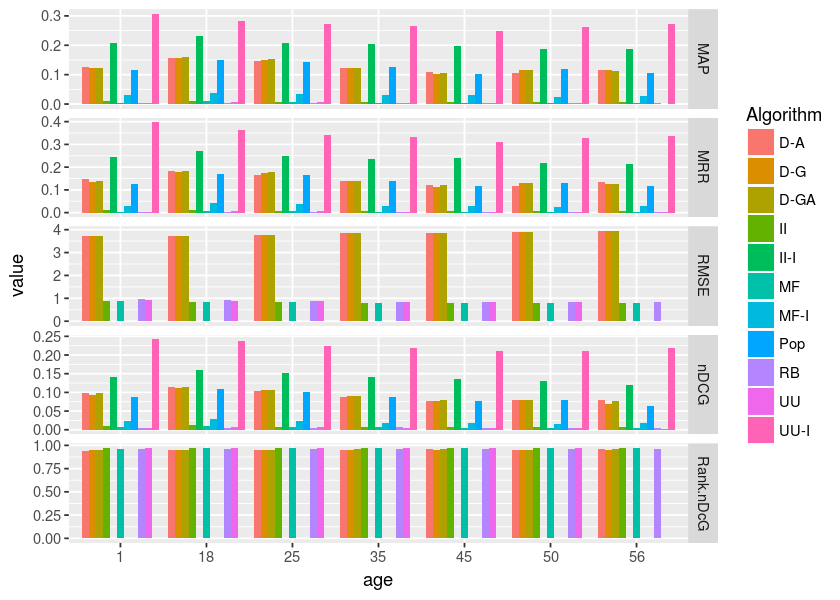

In [11]:
ggplot(age.tall) +
    aes(x=age, y=value, fill=Algorithm) +
    geom_bar(stat="identity", position="dodge") +
    facet_grid(Metric ~ ., scales="free_y")

## Linear Modeling

In [48]:
ap_model = lm(AvgPrec ~ log10(nratings) + gender + age + Algorithm 
              + gender:Algorithm + age:Algorithm + gender:age + log10(nratings):Algorithm,
              data=user.results)
summary(ap_model)


Call:
lm(formula = AvgPrec ~ log10(nratings) + gender + age + Algorithm + 
    gender:Algorithm + age:Algorithm + gender:age + log10(nratings):Algorithm, 
    data = user.results)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.3737 -0.1077 -0.0108 -0.0004  0.9951 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.1474895  0.0168245   8.766  < 2e-16 ***
log10(nratings)               -0.0102672  0.0052541  -1.954 0.050689 .  
genderM                       -0.0012163  0.0093387  -0.130 0.896372    
age18                          0.0101596  0.0148067   0.686 0.492623    
age25                          0.0058969  0.0141882   0.416 0.677690    
age35                         -0.0163581  0.0146897  -1.114 0.265466    
age45                         -0.0397434  0.0159156  -2.497 0.012522 *  
age50                         -0.0361763  0.0162601  -2.225 0.026095 *  
age56                         -0.0159726  0.0171193  

In [49]:
ap_step = stepAIC(ap_model)

Start:  AIC=-224068
AvgPrec ~ log10(nratings) + gender + age + Algorithm + gender:Algorithm + 
    age:Algorithm + gender:age + log10(nratings):Algorithm

                            Df Sum of Sq    RSS     AIC
<none>                                   2272.0 -224068
- gender:age                 6    0.7769 2272.8 -224057
- age:Algorithm             60    4.5140 2276.5 -224056
- gender:Algorithm          10    1.8295 2273.8 -224034
- log10(nratings):Algorithm 10   15.7358 2287.7 -223629


In [53]:
summary(ap_step$model)

    AvgPrec        log10(nratings) gender    age         Algorithm        
 Min.   :0.00000   Min.   :1.176   F:18799   1 : 2442   Length:66440      
 1st Qu.:0.00000   1st Qu.:1.591   M:47641   18:12133   Class :character  
 Median :0.00000   Median :1.959             25:23056   Mode  :character  
 Mean   :0.09747   Mean   :1.964             35:13123                     
 3rd Qu.:0.08835   3rd Qu.:2.307             45: 6050                     
 Max.   :1.00000   Max.   :3.363             50: 5456                     
                                             56: 4180                     

In [55]:
ap_aov = aov(AvgPrec ~ gender + age + Algorithm 
             + gender:Algorithm + age:Algorithm + gender:age,
             data=user.results)
summary(ap_aov)

                    Df Sum Sq Mean Sq  F value   Pr(>F)    
gender               1    1.6    1.60   46.274 1.04e-11 ***
age                  6    5.0    0.84   24.342  < 2e-16 ***
Algorithm           10  515.9   51.59 1492.893  < 2e-16 ***
gender:Algorithm    10    1.2    0.12    3.577 9.26e-05 ***
age:Algorithm       60    4.4    0.07    2.114 1.09e-06 ***
gender:age           6    0.8    0.13    3.718  0.00106 ** 
Residuals        66346 2292.8    0.03                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [36]:
TukeyHSD(aov(AvgPrec ~ gender + age + Algorithm 
             + gender:Algorithm + age:Algorithm + gender:age,
             data=user.results))

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = AvgPrec ~ gender + age + Algorithm + gender:Algorithm + age:Algorithm + gender:age, data = user.results)

$gender
          diff         lwr        upr p adj
M-F 0.01089196 0.007753725 0.01403019     0

$age
               diff           lwr           upr     p adj
18-1   0.0127951187  0.0006387988  2.495144e-02 0.0315197
25-1   0.0057169592 -0.0059469200  1.738084e-02 0.7771516
35-1  -0.0045352479 -0.0166144969  7.544001e-03 0.9262397
45-1  -0.0130579953 -0.0261984151  8.242451e-05 0.0527230
50-1  -0.0103125225 -0.0236570536  3.032009e-03 0.2544143
56-1  -0.0104371931 -0.0243972884  3.522902e-03 0.2929971
25-18 -0.0070781595 -0.0132254275 -9.308915e-04 0.0122018
35-18 -0.0173303666 -0.0242333429 -1.042739e-02 0.0000000
45-18 -0.0258531139 -0.0344794376 -1.722679e-02 0.0000000
50-18 -0.0231076411 -0.0320418080 -1.417347e-02 0.0000000
56-18 -0.0232323118 -0.0330622195 -1.340240e-02 0.0000000
3

In [33]:
rr_model = lm(RecipRank ~ log10(nratings) + gender + age + Algorithm 
              + gender:Algorithm + age:Algorithm + gender:age + log10(nratings):Algorithm,
              data=user.results)
summary(rr_model)


Call:
lm(formula = RecipRank ~ log10(nratings) + gender + age + Algorithm + 
    gender:Algorithm + age:Algorithm + gender:age + log10(nratings):Algorithm, 
    data = user.results)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.48691 -0.12651 -0.01217 -0.00078  0.99523 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.1716025  0.0204447   8.393  < 2e-16 ***
log10(nratings)               -0.0119775  0.0063847  -1.876 0.060661 .  
genderM                       -0.0031153  0.0113482  -0.275 0.783685    
age18                          0.0143771  0.0179928   0.799 0.424267    
age25                          0.0046832  0.0172412   0.272 0.785907    
age35                         -0.0224657  0.0178506  -1.259 0.208201    
age45                         -0.0477465  0.0193403  -2.469 0.013561 *  
age50                         -0.0506141  0.0197589  -2.562 0.010422 *  
age56                         -0.0184503 